# Use Case 5: Gene set enrichment analysis

## Step 1: Importing packages and setting up your notebook.

We start the notebook by importing the standard packages for data science. These are useful for analyzing data stored in dataframes and for plotting the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import gseapy as gp
from gseapy.plot import barplot, dotplot

Our cancer data and a variety of accessory functions are provided in the cptac package.

In [ ]:
import cptac
en = cptac.Endometrial()

## Step 2: Joining dataframes

For this example we will be separating the protein abudance based on whether the sample is tumor or non-tumor tissue. This information is stored in the "Proteomics_Tumor_Normal" column in the clinical dataframe. We first join the clinical information into the proteomics dataframe utilizing the <code>en.join_metadata_to_omics</code> function.

In [3]:
tumorProt = en.join_metadata_to_omics(metadata_df_name="clinical", omics_df_name="proteomics", metadata_cols='Proteomics_Tumor_Normal')

## Step 3: Organizing the data

We then separate the proteomics into two groups, based on whether the patient is categorized as "Tumor" or "Normal". If you look at the values in the tumorProt dataframe, you'll see that "Normal" actually includes several different types of normal tissue--adjacent normal, normal tissue from other individuals called 'enriched normal', etc. We make a single value out of this in the code below calling everything besides "Tumor" a "Normal" sample.

In [4]:
#Retrieve boolean array of true values
tumor_bool = tumorProt['Proteomics_Tumor_Normal'] == "Tumor"
normal_bool = tumorProt['Proteomics_Tumor_Normal'] != "Tumor"
#Use boolean array to select for appropriate patients
tumor = tumorProt[tumor_bool]
normal = tumorProt[normal_bool]

## Step 4: Perform statistical tests

Next, we find the genes that are upregulated in each partition using Welch's t-test (a variation on the two sample t-test due to different variances between the two groups) to compare the "Tumor" individuals with the "Normal" individuals for each gene.

In [5]:
#Create array variables to hold the significant genes for each partition
tumor_genes = []
normal_genes = []
#Grab the genes of interest, ignoring the MSI column in the dataframe
genes = tumor.columns[1:]
#Correct alpha level for multiple testing by dividing the standard .05 by the number of genes to be analyzed
threshold = .05 / len(genes)
#Perform Welch's t-test(different variances) on each gene between the two groups
for gene in genes:
    tumor_gene_abundance = tumor[gene]
    normal_gene_abundance = normal[gene]
    pvalue = stats.ttest_ind(tumor_gene_abundance, normal_gene_abundance, equal_var = False, nan_policy='omit').pvalue
    #If the P-value is significant, determine which partition is more highly expressed
    if pvalue < threshold:
        if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
            tumor_genes.append(gene.split("_")[0])
        elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
            normal_genes.append(gene.split("_")[0])
#Optional check of number of genes in each partition
print("Proteomics Tumor Genes:", len(tumor_genes))
print("Proteomics Normal Genes:", len(normal_genes))

Proteomics Tumor Genes: 2154
Proteomics Normal Genes: 2237


## Step 5: Gene set enrichment analysis

We then use the genes that are up-regulated in these partitions to perform a Gene Set Enrichment Analysis using the <code>gp.enrichr()</code> function (<code>gp</code> being the specified abbreviation for the imported gseapy package).

In [6]:
tumor_enr = gp.enrichr(gene_list = tumor_genes, description='Tumor partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)
normal_enr = gp.enrichr(gene_list = normal_genes, description='Normal partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)

We can view the data as a table by using the <code>obj.res2d</code> command (<code>obj</code> being the variable name specified in the previous step). The Gene Set Enrichment Analysis returns a list of pathways the genes provided are involved in, based on a significant adjusted P-value.

In [7]:
tumor_enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2016,Ribosome_Homo sapiens_hsa03010,81/137,2.901971e-43,8.328657e-41,2.144078e-22,6.153504e-20,-1.746138,171.026834,RPL4;RPL5;MRPS15;RPL30;RPL3;MRPS11;RPLP1;RPLP0...
1,KEGG_2016,Proteasome_Homo sapiens_hsa03050,32/44,4.996777e-22,7.170375e-20,2.988372e-11,4.288313e-09,-1.687623,82.774666,PSMD12;PSMD11;PSMD14;PSMD13;PSMA7;PSMB10;PSMD8...
2,KEGG_2016,Metabolic pathways_Homo sapiens_hsa01100,210/1239,7.212527e-12,6.899984e-10,8.962487e-04,2.004763e-02,-1.961922,50.333509,PANK1;ENO1;EPRS;IL4I1;C1GALT1C1;NSDHL;PNP;SCP2...
3,KEGG_2016,Lysosome_Homo sapiens_hsa04142,41/123,1.496473e-11,1.073719e-09,2.652680e-06,2.537731e-04,-1.699249,42.354336,CD63;ASAH1;HEXB;CTSZ;HEXA;CLTC;CLTA;LIPA;CTSS;...
4,KEGG_2016,Protein processing in endoplasmic reticulum_Ho...,48/169,1.730328e-10,9.932085e-09,1.486739e-05,1.066735e-03,-1.718807,38.634550,VCP;HSP90AB1;PRKCSH;SAR1B;RPN1;RRBP1;RNF5;HERP...


In [8]:
normal_enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2016,Complement and coagulation cascades_Homo sapie...,45/79,5.520692e-23,1.468504e-20,7.294727e-14,1.087878e-11,-1.824138,93.488831,CFD;CPB2;SERPINA1;CFH;C1S;SERPINC1;C1R;PROS1;C...
1,KEGG_2016,Focal adhesion_Homo sapiens_hsa04510,74/202,1.656914e-21,2.203695e-19,8.179537e-14,1.087878e-11,-1.896862,90.763583,ITGB3;PTEN;PIK3CD;ILK;LAMC1;MYLK3;MYLK;CRKL;AK...
2,KEGG_2016,Endocytosis_Homo sapiens_hsa04144,75/259,3.293706e-15,2.920420e-13,6.382194e-10,5.658878e-08,-1.912425,63.773169,ZFYVE9;ARPC1A;WIPF3;CLTB;SNX12;AP2A1;ARRB1;WAS...
3,KEGG_2016,Pathways in cancer_Homo sapiens_hsa05200,96/397,1.323995e-13,8.243961e-12,7.929762e-09,4.218633e-07,-2.029699,60.186566,CDKN1B;PTEN;PIK3CD;LAMC1;FGF1;FGF2;CRKL;IKBKB;...
4,KEGG_2016,MAPK signaling pathway_Homo sapiens_hsa04010,71/255,1.549617e-13,8.243961e-12,7.484993e-09,4.218633e-07,-1.895949,55.922153,ATF2;HSPB1;ARRB1;FGF1;FGF2;CRKL;IKBKB;RPS6KA4;...


## Step 7: Plot the p-values

We can better visualize these tables and the significant pathways detected through the gseapy imported <code>barplot()</code> function, which takes an enrichr table and a title as parameters.

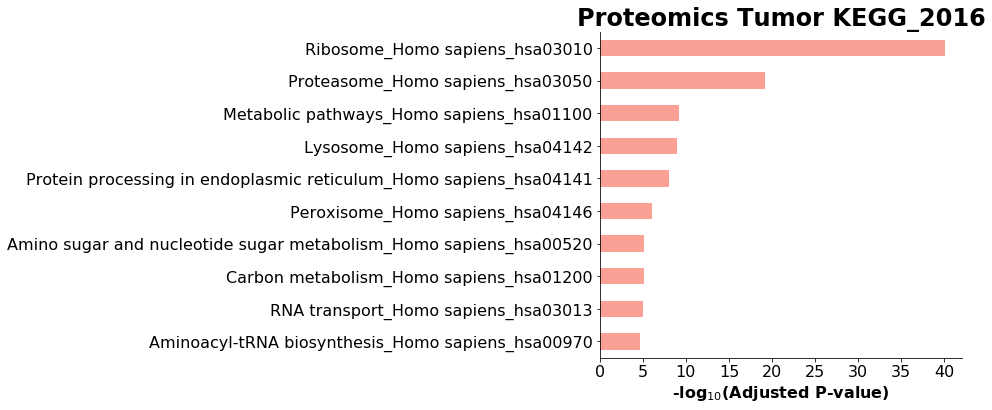

In [9]:
barplot(tumor_enr.res2d,title="Proteomics Tumor KEGG_2016")

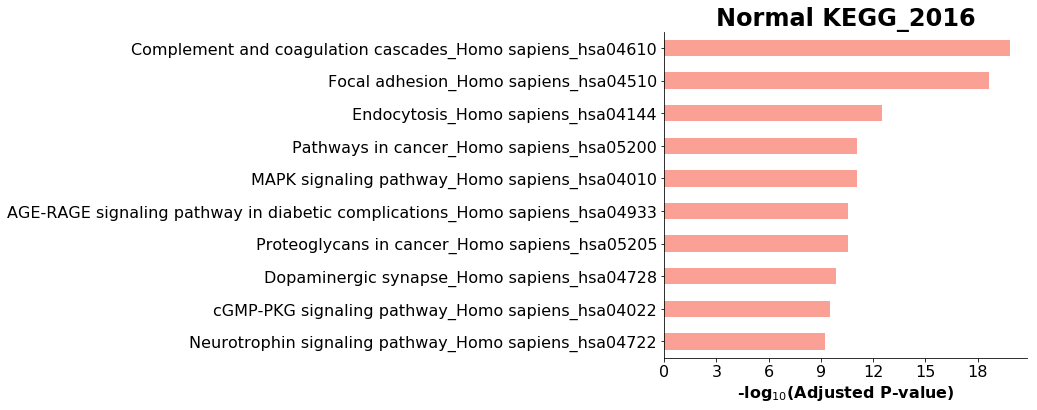

In [10]:
barplot(normal_enr.res2d,title="Normal KEGG_2016")

## Discussion

When comparing these barplots, we can observe the "Tumor" group has one pathway expressed at a very significant adjusted P-value, while the other pathways are expressed at a less significant P-value. The single pathway is the Ribosome pathway, which could be attributed to the "Tumor" genes disrupting ribosome activity. In comparison, the "Normal" group has a higher count of high significant P-values.